# Ski Workout Detection

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pathlib
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq, rfft, rfftfreq

from data_processing.config import BOOT_LABEL_FILE, POLE_LABEL_FILE, IMU_DATA_DIR
from data_processing.labels_util import get_labels_data, LabelCol, get_workouts_epoch_bounds, get_workouts_sensor
from data_processing.imu_util import list_imu_abspaths, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, to_row_range
from data_processing.enums import Activity

# import data types
from pandas import DataFrame
from numpy import ndarray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

### Load data
We're using the "small sample" consisting of only two boot and two pole tests. We extract the segments where athletes are performing workouts (performing the 3-minute test) from the full IMU data.

In [4]:
# Get workouts time boundaries
labels = get_labels_data(BOOT_LABEL_FILE, Activity.Boot)
#labels = get_labels_data(POLE_LABEL_FILE, Activity.Pole)
w1, w2 = get_workouts_epoch_bounds(labels)
sensor1, sensor2 = get_workouts_sensor(labels)

# Load full IMU data
imu_data1 = load_imu_data(list_imu_abspaths(sensor_name = sensor1, sensor_type=Sensor.Accelerometer)[0])
imu_data2 = load_imu_data(list_imu_abspaths(sensor_name = sensor2, sensor_type=Sensor.Accelerometer)[0])

# Get IMU data of workouts
w1 = to_row_range(imu_data1, w1[0], w1[1], expected_range=3*60, expected_range_error=10)
w2 = to_row_range(imu_data2, w2[0], w2[1], expected_range=3*60, expected_range_error=10)
imu_data1 = imu_data1[w1[0]:w1[1]+1,:]
imu_data2 = imu_data2[w2[0]:w2[1]+1,:]

Check that we extracted the workouts correctly.

<IPython.core.display.Javascript object>


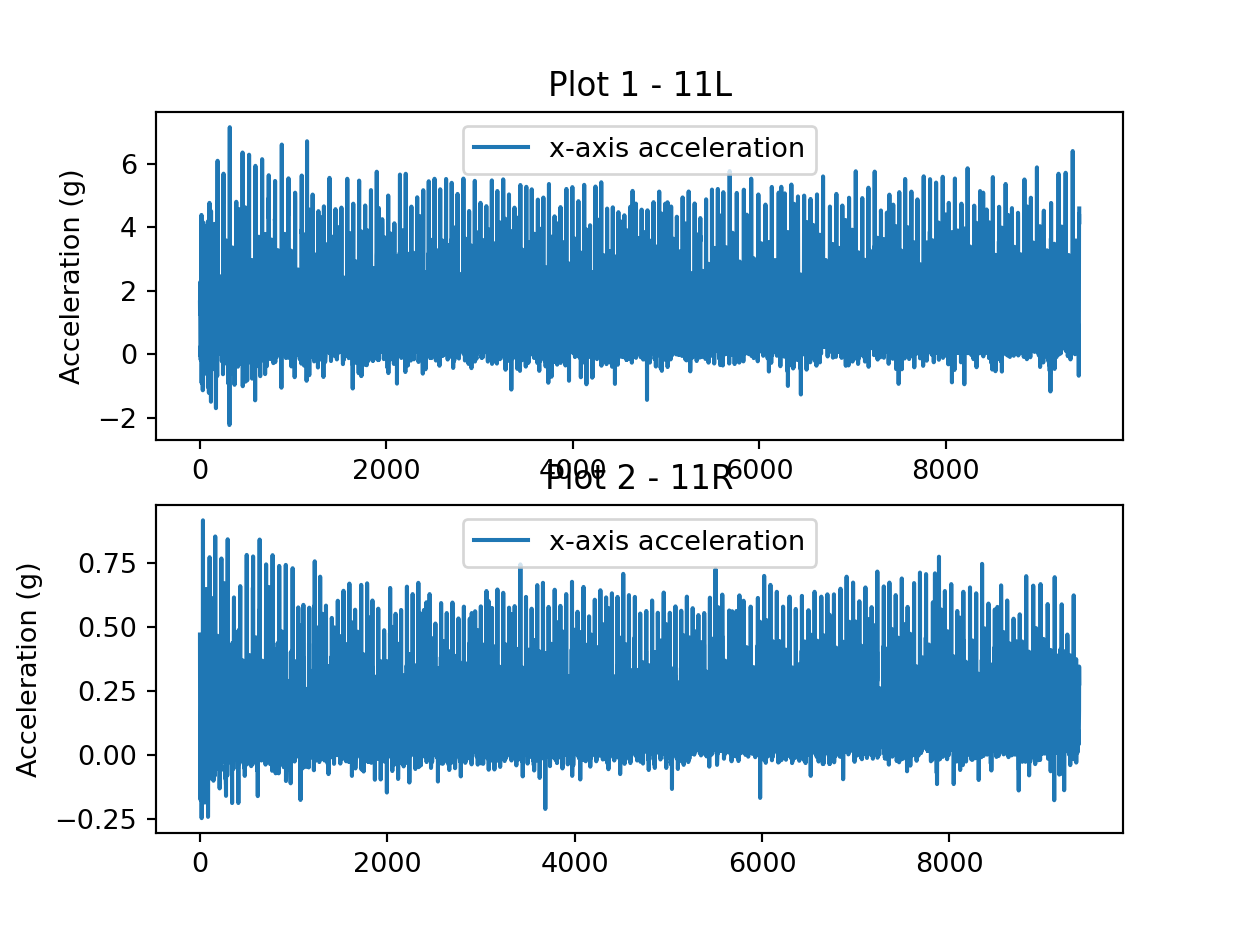

In [3]:
f, (plot1, plot2) = pyplot.subplots(2,1)

plot1.plot(imu_data1[:, ImuCol.XACCEL], label = "x-axis acceleration")
plot1.set_title('Plot 1 - 11L')
plot1.set(ylabel='Acceleration (g)')
plot1.legend()

plot2.plot(imu_data2[:, ImuCol.XACCEL], label = "x-axis acceleration")
plot2.set_title('Plot 2 - 11R')
plot2.set(ylabel='Acceleration (g)')
plot2.legend()

pyplot.rcParams['figure.figsize'] = [9, 5]
pyplot.show()

### IMU data pre-processing
We will need to pre-process the IMU data to
* **Fix unusual epoch times**. Many data sets have epoch times jumping around rather than increasing linearly from the first to the last data point
* **Resample data uniformly**. The sampling interval isn't consistent. We want the time between each data point to be the same. Uniformly sampled data is important for Fast Fourier Transform to work.

[20.]
[20.]


<IPython.core.display.Javascript object>


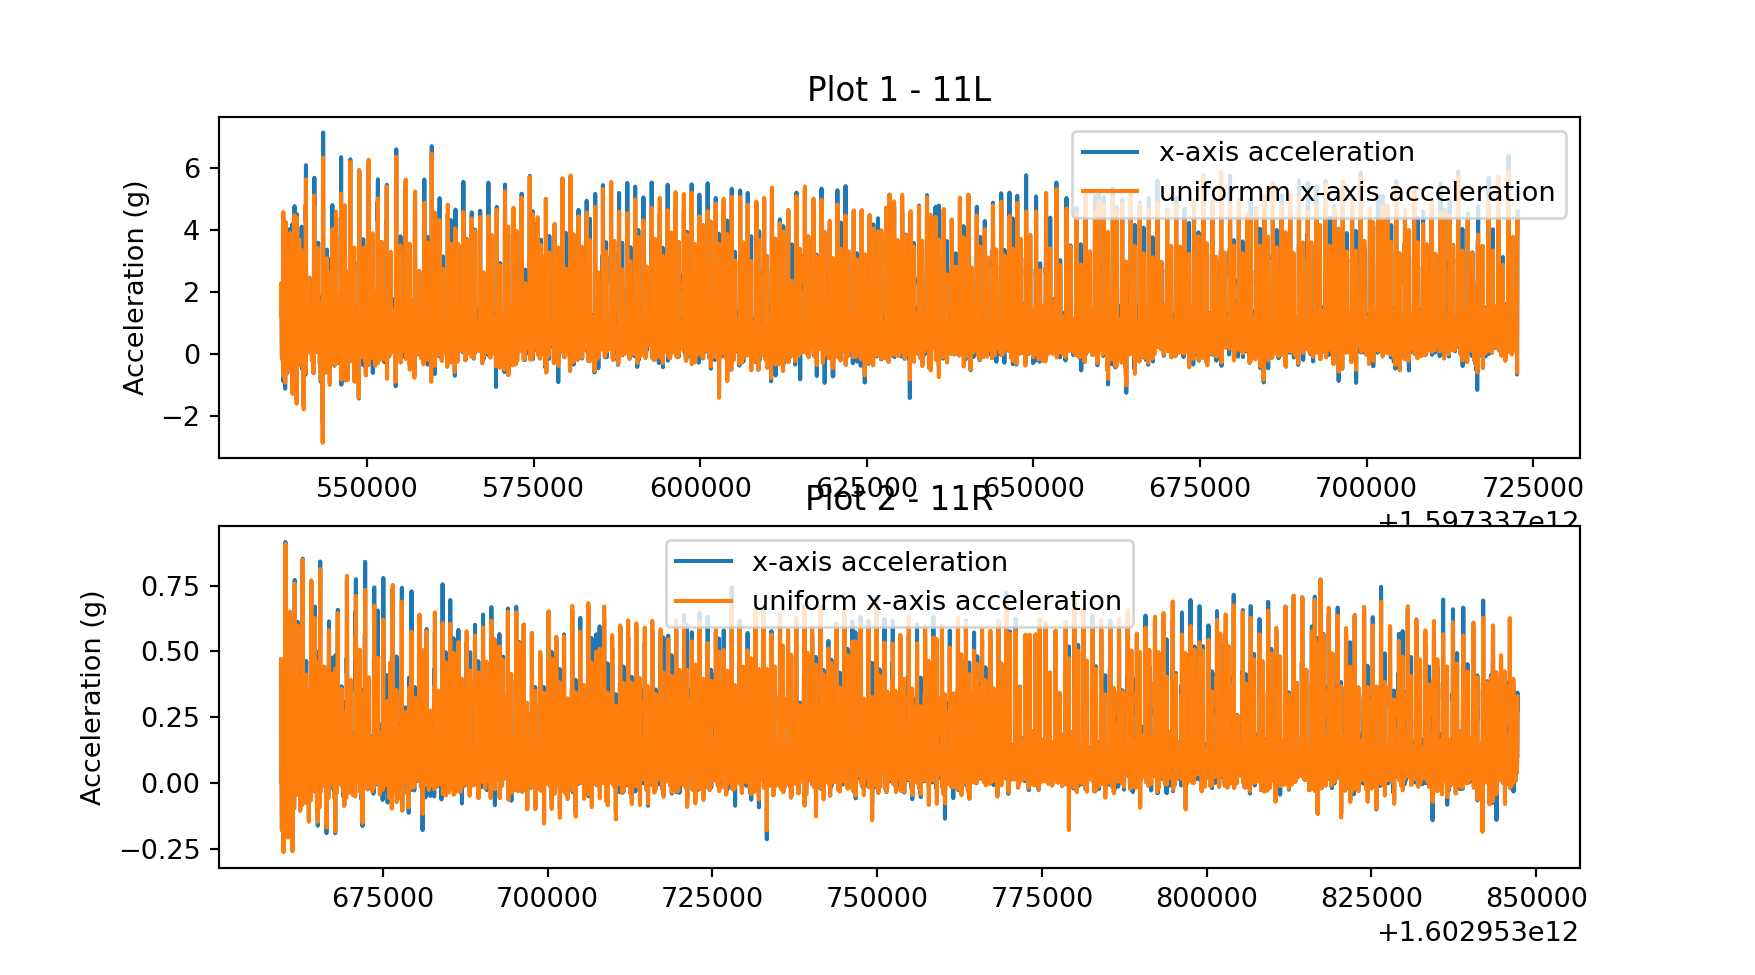

In [4]:
imu_data1 = fix_epoch(imu_data1)
imu_data2 = fix_epoch(imu_data2)

unif_imu_data1 = resample_uniformly(imu_data1)
unif_imu_data2 = resample_uniformly(imu_data2)

# Make sure timestamps are uniform
print(np.unique(np.diff(unif_imu_data1[:, ImuCol.TIME])))
print(np.unique(np.diff(unif_imu_data2[:, ImuCol.TIME])))

# Compare pre and post resampling data. Make sure they're similar
f, (plot1, plot2) = pyplot.subplots(2,1)

plot1.plot(imu_data1[:, ImuCol.TIME], imu_data1[:, ImuCol.XACCEL], label = "x-axis acceleration")
plot1.plot(unif_imu_data1[:, ImuCol.TIME], unif_imu_data1[:, ImuCol.XACCEL], label = "uniformm x-axis acceleration")
plot1.set_title('Plot 1 - 11L')
plot1.set(ylabel='Acceleration (g)')
plot1.legend()

plot2.plot(imu_data2[:, ImuCol.TIME], imu_data2[:, ImuCol.XACCEL], label = "x-axis acceleration")
plot2.plot(unif_imu_data2[:, ImuCol.TIME], unif_imu_data2[:, ImuCol.XACCEL], label = "uniform x-axis acceleration")
plot2.set_title('Plot 2 - 11R')
plot2.set(ylabel='Acceleration (g)')
plot2.legend()

pyplot.rcParams['figure.figsize'] = [9, 5]
pyplot.show()

# commit to uniformly sampled data
imu_data1 = unif_imu_data1
imu_data2 = unif_imu_data2

Now we need to **normalize** the data.

<u>**TODO**</u>: make normalization safer by removing outliers. An outlier with extremely large acceleration will make "max" very inaccurate.

<IPython.core.display.Javascript object>


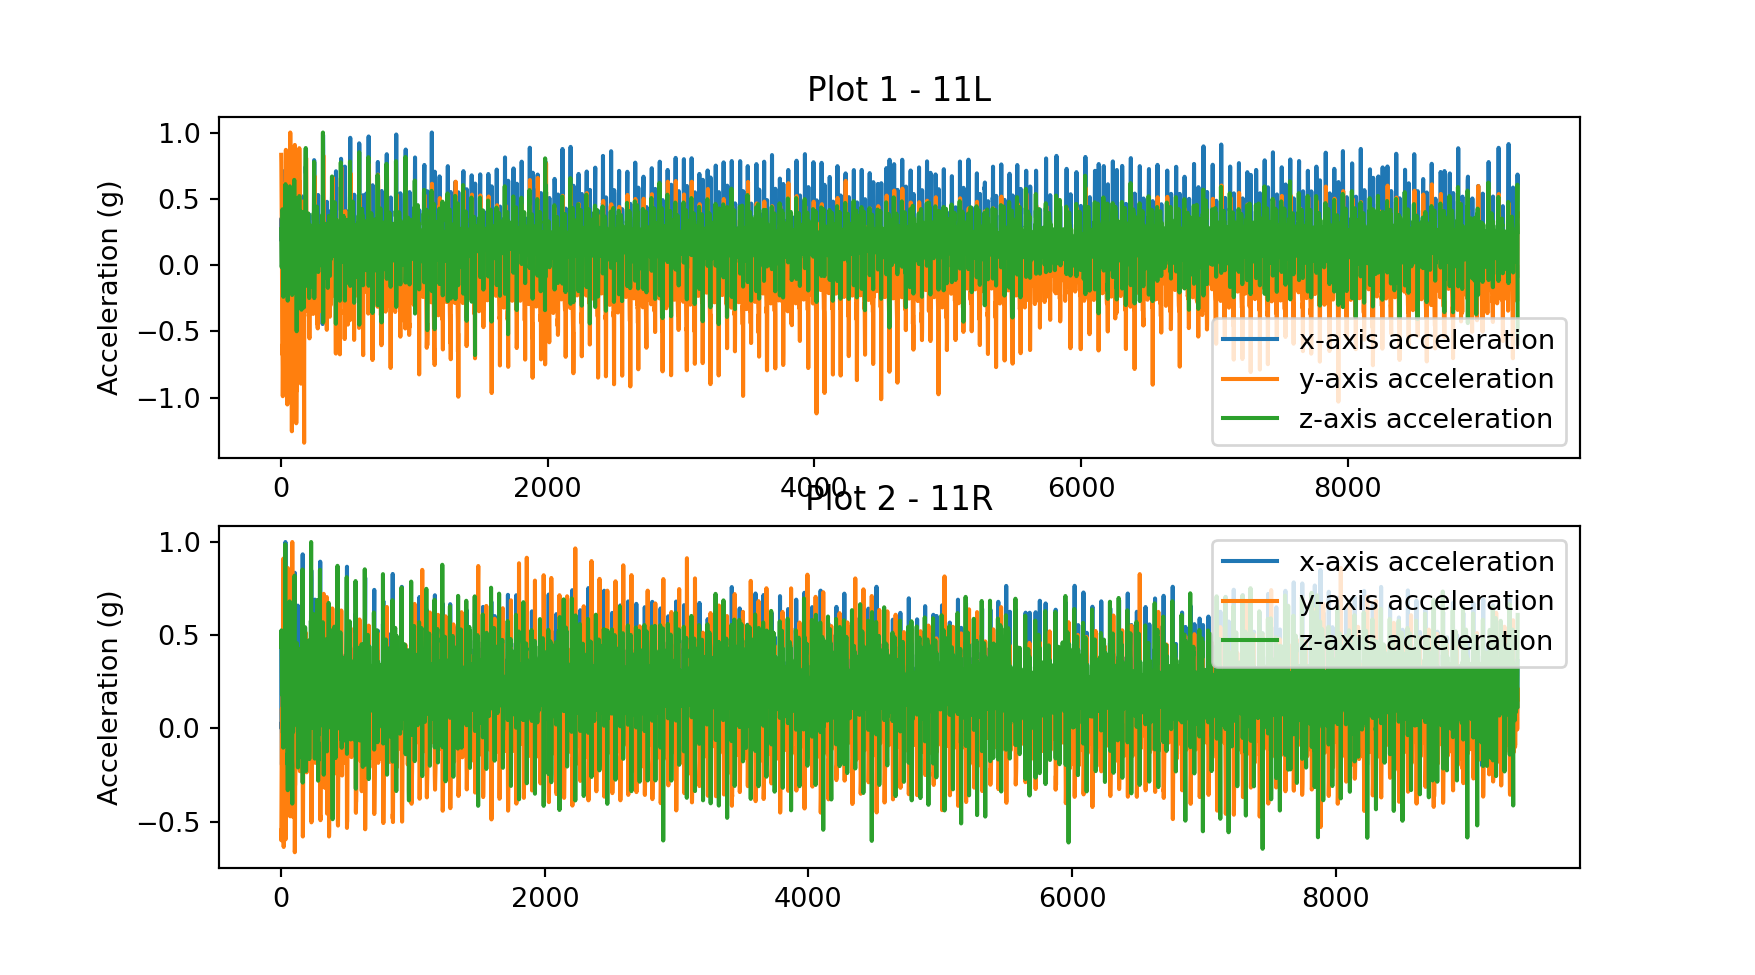

In [5]:
imu_data1[:, ImuCol.XACCEL] /= imu_data1[:, ImuCol.XACCEL].max()
imu_data1[:, ImuCol.YACCEL] /= imu_data1[:, ImuCol.YACCEL].max()
imu_data1[:, ImuCol.ZACCEL] /= imu_data1[:, ImuCol.ZACCEL].max()

imu_data2[:, ImuCol.XACCEL] /= imu_data2[:, ImuCol.XACCEL].max()
imu_data2[:, ImuCol.YACCEL] /= imu_data2[:, ImuCol.YACCEL].max()
imu_data2[:, ImuCol.ZACCEL] /= imu_data2[:, ImuCol.ZACCEL].max()

# Plot
f, (plot1, plot2) = pyplot.subplots(2,1)

plot1.plot(imu_data1[:, ImuCol.XACCEL], label = "x-axis acceleration")
plot1.plot(imu_data1[:, ImuCol.YACCEL], label = "y-axis acceleration")
plot1.plot(imu_data1[:, ImuCol.ZACCEL], label = "z-axis acceleration")
plot1.set_title('Plot 1 - 11L')
plot1.set(ylabel='Acceleration (g)')
plot1.legend()

plot2.plot(imu_data2[:, ImuCol.XACCEL], label = "x-axis acceleration")
plot2.plot(imu_data2[:, ImuCol.YACCEL], label = "y-axis acceleration")
plot2.plot(imu_data2[:, ImuCol.ZACCEL], label = "z-axis acceleration")
plot2.set_title('Plot 2 - 11R')
plot2.set(ylabel='Acceleration (g)')
plot2.legend()

pyplot.rcParams['figure.figsize'] = [9, 5]
pyplot.show()

## Workout detection classifier

### Apply Discrete Fourier Transform (DFT) to data
<u>**TODO**</u> Perform windowing to make DFT more accurate. The data has an integer number of cycles (of all frequencies I think) for DFT to work accurately. Since we cannot guarantee this, we must use a windowing method.

<IPython.core.display.Javascript object>


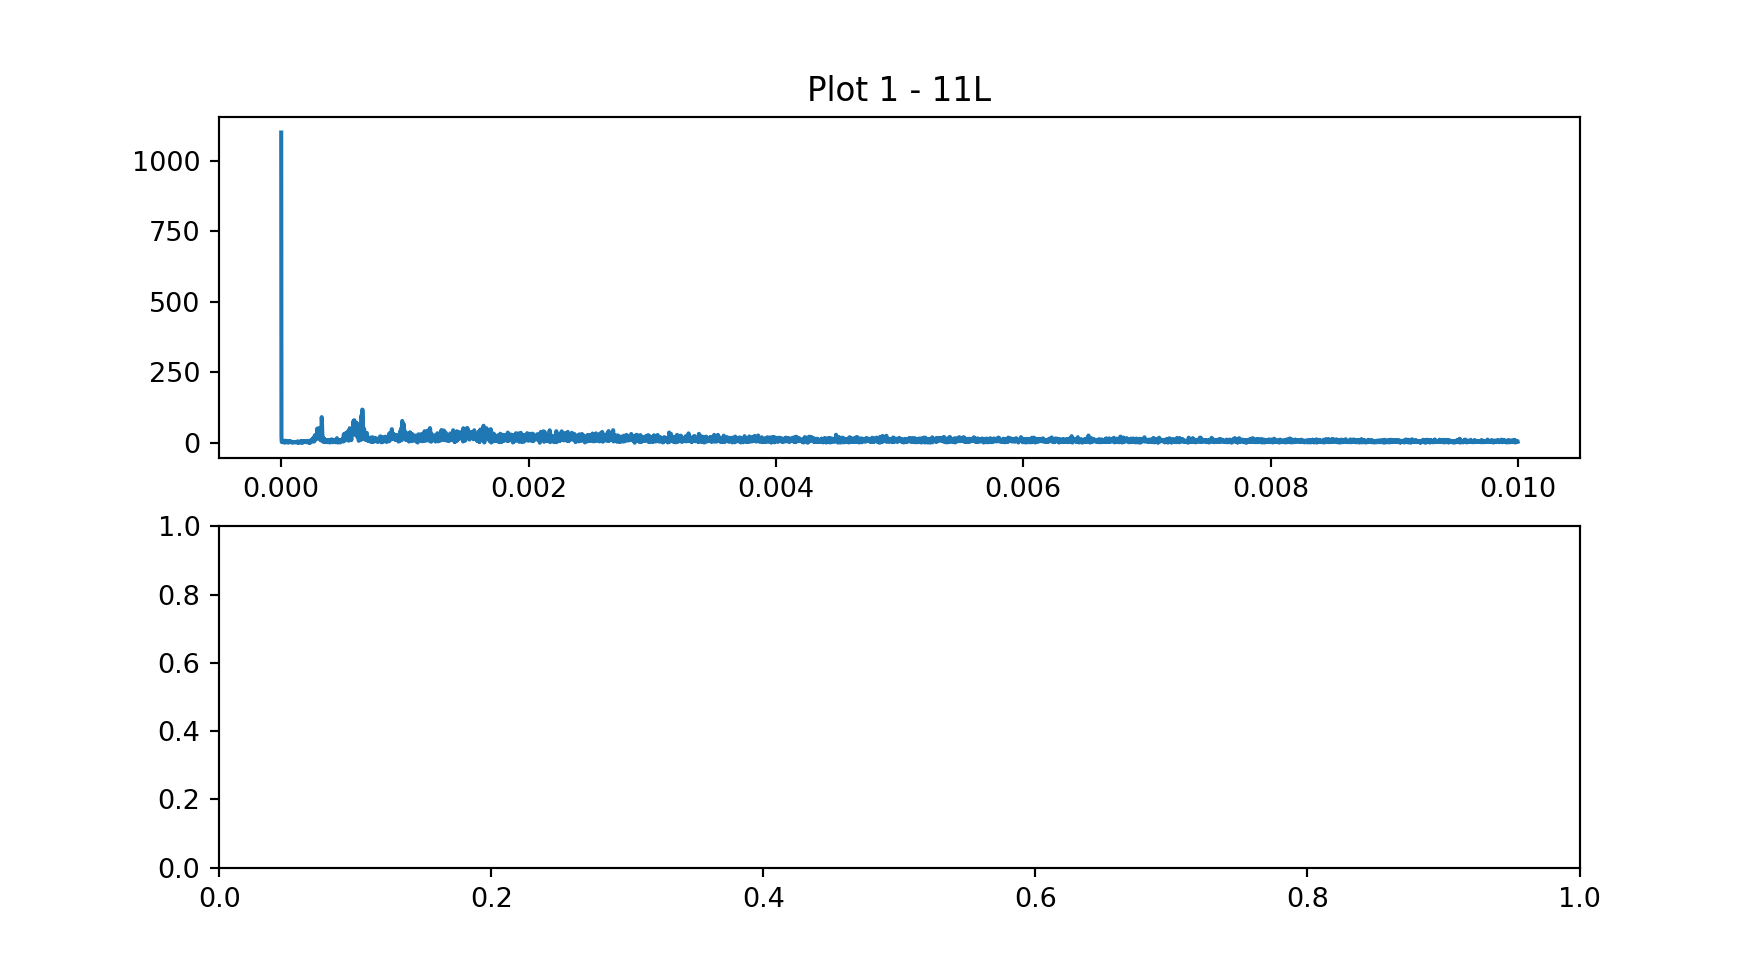

In [6]:
N = imu_data1.shape[0]
DURATION = (imu_data1[:, ImuCol.TIME].max() - imu_data1[:, ImuCol.TIME].min()) / 1000 # in seconds
SAMPLE_RATE = DURATION / N # Hz

yfft = rfft(imu_data1[:, ImuCol.XACCEL])
xfft = rfftfreq(N, 1 / SAMPLE_RATE)

# Plot
f, (plot1, plot2) = pyplot.subplots(2,1)
plot1.plot(xfft, np.abs(yfft))
plot1.set_title('Plot 1 - 11L')

pyplot.show()